Nome: Joel Alcídio Varela Mendonça

RA: 139884

Curso:Doutorando Eng. Elétrica



# Ex06 - Desafio de classificação: detecção de tumores no cérebro

O objetivo deste desafio é classificar um conjunto de imagens 2D de cérebros saudáveis e cérebros contendo tumores. As imagens estão no diretório **Dados/Ex06/Brain_Tumor_Dataset**, subdivididas em conjuntos de treino, validação e teste. Note que as labels do conjunto de teste não estão disponíveis!

Sinta-se livre para utilizar qualquer classificador/técnica que desejar, mas lembre-se de justificar suas escolhas! A ideia é que você tente utilizar tudo que foi aprendido até aqui para obter um classificador com o melhor desempenho possível. Após definir o seu modelo final, você deve obter as predições para o conjunto de teste. Assim, além deste notebook com seus experimentos e comentários, você deve enviar também um arquivo com as suas predições para o conjunto de teste. Nas instruções do exercício no classroom você vai encontrar informações mais específicas sobre como enviar suas predições para o conjunto de teste.

**ATENÇÃO**: a nota deste exercício não vai se basear no desempenho final do seu classificador! Mais detalhes sobre os critérios de avaliação serão postados no classroom em breve.

Sugestões:
- Aplique técnicas de data augmentation;
- Tente utilizar modelos pré-treinados e técnicas de transfer learning;
- Tente modificar os hiperparâmetros (Optimizer, Learning-Rate, Número de Épocas, Tamanho do Batch, etc) para obter modelos com melhor desempenho;
- Utilize alguma ferramenta para acompanhamento e visualização das curvas de treino e validação (loss e acurácia). Por ex.: [Neptune](https://neptune.ai) ou [Wandb](https://wandb.ai/). Compare as diferentes versões de modelos utilizadas.

In [3]:
# Instalando bibliotecas no Colab
!pip install pytorch-lightning torchinfo torchmetrics --quiet
!pip install pyngrok
!pip install -U 'mlflow>=1.0.0' --quiet
!pip install neptune --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
# Importando as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchmetrics import Accuracy
import torchinfo
from torchsummary import summary
import multiprocessing as mp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext tensorboard

# Definindo o nome da pasta compartilhada
# IMPORTANTE: substitua "NOME_DA_PASTA_COMPARTILHADA" abaixo pelo nome correspondente
pasta_compartilhada = "NOME_DA_PASTA_COMPARTILHADA"

In [5]:

# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Estamos trabalhando na distinção entre imagens pertencentes a dois grupos distintos: 'health' (rótulo 0) e 'tumor' (rótulo 1). Cada imagem é categorizada em uma dessas duas classes: rótulo 0 ou rótulo 1. Como temos apenas duas classes para representar, o número total de classes, definido como hparams["nout"], é igual a 2.

Além disso, uma vez que estamos lidando com imagens coloridas no formato RGB, em que cada pixel é representado por três valores correspondentes às intensidades de vermelho, verde e azul, o parâmetro que indica o número de canais, hparams["nin"], é definido como três.

In [6]:
# Os hiperparametros da minha rede

hparams = {"experiment_name": "Test_ResNet_1",  # experiment name identifies the run for later
           "max_epochs": 50,  # number of epochs to train
           "batch_size_train": 64,  # size of batch
           "batch_size_val": 64,  # size of batch
           "nworkers": mp.cpu_count(),  # number of workers to use in parallel loading
           "nout": 2,  # number of classes
           "nin": 3,  # number of channels of the input image
           "lr": 1e-5,  # learning rate
           "wd": 1e-5,  # weight decay for optimizer
           "cpu": False,  # forces using the CPU,
           "model_pre_trained": False,
           }



Analisando os conjuntos de imagens de treinamento e validação, observou-se que as imagens apresentavam dimensões variadas. Para lidar com essa disparidade, optou-se por aplicar a transformação **transforms.Resize((100, 100))**, redimensionando todas as imagens para o tamanho uniforme de 100x100 pixels.

Além disso, notou-se que várias imagens possuíam escritas nas laterais, o que poderia interferir na análise. Para corrigir isso, foi utilizada a transformação **CenterCrop(90)**, que corta a imagem ao redor do centro. O argumento (90) indica que a imagem foi cortada para ter uma dimensão de 90 pixels em ambas as direções (altura e largura).

Com o objetivo de reduzir o viés e a variabilidade nos valores dos pixels das imagens de entrada da rede neural, aplicou-se a transformação **Normalize(mean=[0.5], std=[0.5])**. Esta transformação ajusta os valores dos pixels para que a média seja 0.5 e o desvio padrão seja 0.5 em cada canal da imagem após a normalização. Além disso, normalizar as imagens para um intervalo específico pode ajudar a estabilizar o processo de treinamento, evitando que os valores dos gradientes se tornem muito pequenos ou muito grandes.
Essas técnicas de pré-processamento desempenham um papel fundamental na preparação dos dados para o treinamento de modelos de aprendizado de máquina, resultando em melhores resultados, maior eficiência computacional e maior capacidade de generalização.



In [7]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets.folder import default_loader

'''
Carrega e pré-processa conjuntos de dados de treinamento, validação e teste para
o problema de classificação de imagem cerebral com e sem tumor
'''

to_float_transform = transforms.Lambda(lambda x: x.float())

# Caminho para os dados de treinamento e validação
train_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/train/"
val_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/val/"
test_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/test/"


def loader_name(path):
    # Carregar a imagem
    image = default_loader(path)
    # Obter o nome do arquivo da imagem
    filename = os.path.basename(path)
    return image, filename

# aplica o pré processamento
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensiona as imagens para 100x100 pixels
    transforms.CenterCrop(90), # corta as imagens
    transforms.ToTensor(),           # Converte as imagens para tensores
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normaliza os pixels das imagens
    ])

# Carrega os dados de treinamento, validação e teste
train_data = datasets.ImageFolder(root=train_data_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_data_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_data_dir, transform=transform)

# Essa variavel armazenas as imagens do conjunto de teste junto com os respectivos nomes
test_data_aux = datasets.ImageFolder(root=test_data_dir, loader = loader_name, transform=transform)



Ao analisar o número de imagens nos conjuntos de treinamento, notou-se que o conjunto de treinamento da classe *health* tinha 37 imagens a menos do que o conjunto de treinamento da classe *tumor*, enquanto o conjunto de validação da classe *health* tinha 20 imagens a menos do que o conjunto de validação da classe *tumor*. Para abordar esse desequilíbrio entre as quantidades de imagens das classes "health" e "tumor" nos conjuntos de treinamento e validação, vamos empregar a técnica de pré processamento conhecido como aumento de dados(data augmentation). Essa abordagem permite ampliar a diversidade e a quantidade do conjunto de dados de treinamento, aplicando transformações aleatórias às imagens originais, preservando sua semântica original.

**Explicação do impacto das transformações no desempenho da classificação:**

As **transformações de aumento de dados** são essenciais para melhorar o desempenho de modelos de aprendizado profundo. Elas aumentam a robustez do modelo, reduzem o overfitting, aumentam a variabilidade dos dados e melhoram a capacidade de generalização. Isso é alcançado introduzindo variações nos dados de treinamento, permitindo que o modelo aprenda padrões mais gerais e evite memorizar exemplos específicos do conjunto de treinamento.


As transformações aplicadas durante o treinamento de uma Rede Neural Convolucional (CNN) têm impactos significativos no desempenho da classificação. O **redimensionamento** das imagens garante que todas as entradas tenham o mesmo tamanho, o que é necessário para as CNNs. A **inversão horizontal** e a **rotação aleatória** aumentam a diversidade dos dados de treinamento, tornando o modelo mais robusto a variações na orientação e rotação das imagens. **Ajustes aleatórios no brilho, contraste, saturação e matiz** das imagens podem melhorar a robustez do modelo a variações nessas propriedades. O **desfoque gaussiano** pode tornar o modelo mais robusto a variações na nitidez das imagens, mas se for muito forte, pode prejudicar o desempenho da classificação.

É importante destacar que o aumento de dados para o conjunto de treinamento é realizado usando as imagens originais do conjunto de treinamento, enquanto o aumento de dados para o conjunto de validação é feito usando as imagens originais do conjunto de validação. Essa abordagem garante que os conjuntos de treinamento e validação sejam expandidos de maneira apropriada, mantendo a consistência entre os dados originais e os dados aumentados em cada conjunto. Após aplicar o processo de aumento de dados (data augmentation) nos conjuntos de treinamento e validação, as imagens originais são concatenadas com as imagens resultantes do processo de data augmentation.

In [8]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder


# Função para realizar augmentation em imagens
def augmentation_images(_dataset_, num_aug_img, lbl):
    # Inicialize uma lista para armazenar as imagens aumentadas
    augmented_images = []

    # Contador para acompanhar o número de imagens aumentadas
    augmented_count = 0

    # Transformações de aumento de dados desejadas
    augmentation = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5), # Inverte horizontalmente a imagem com probabilidade de 50%
      transforms.RandomRotation(degrees=(-45, 45)), # Rotaciona a imagem por um ângulo aleatório dentro do intervalo [-45, 45] graus
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Ajusta aleatoriamente o brilho, contraste, saturação e matiz da imagem
      transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Aplica um desfoque gaussiano à imagem com um kernel de tamanho 5x5 e desvio padrão de 2
    ])

    # Iterar sobre o dataset para encontrar imagens com o rótulo desejado
    for image, label in _dataset_:
        if label == lbl and augmented_count < num_aug_img: # verifica o rotulo desejado e vericado a quantidade de imagem a ser gerada
            # Aplica as transformações de aumento na imagem
            augmented_image = augmentation(image)
            augmented_images.append((augmented_image, label))
            augmented_count += 1

    return augmented_images




# Número de imagens de treino de rotulo 0 a ser gerado
num_aug_imgs_train = 37
# Número de imagens de validação de rotulo 0 a ser gerado
num_aug_imgs_val = 20

# o rotulo da imagem a ser gerada
label_to_augment = 0


# Realiza o processo de augmentation nas imagens, lembrando o train_data e val_data
# são os conjuntos de dados originais
augmented_images_train = augmentation_images(train_data, num_aug_imgs_train, label_to_augment)
augmented_images_val = augmentation_images(val_data, num_aug_imgs_val, label_to_augment)

# Cria um novo conjunto de dados concatenando as imagens originais com as imagens aumentadas
combined_data_set_train = torch.utils.data.ConcatDataset([train_data, augmented_images_train])
combined_data_set_val = torch.utils.data.ConcatDataset([val_data, augmented_images_val])



Antes de iniciar a etapa de treinamento é sempre recomendado visualizar as imagens do datasets de treino e de validação


Shape do batch: torch.Size([82, 3, 90, 90])


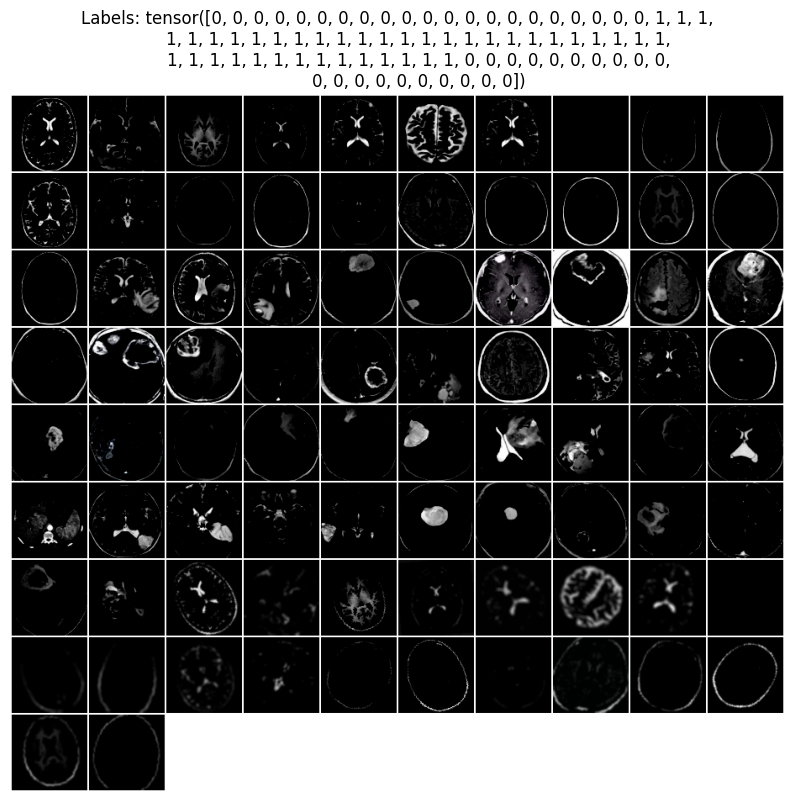

In [10]:

def show_image(dataset, size):

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=size, shuffle=False)

  # Itera sobre o primeiro lote de dados 'data_loader'
  images, labels = next(iter(data_loader))


  print("Shape do batch:", images.shape)
  img_grid = make_grid(images, nrow=10, pad_value=1)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(img_grid.permute(1, 2, 0).numpy())
  plt.title(f'Labels: {labels}')
  plt.axis('off')
  plt.show()


#show_image(combined_data_set_train, 180) # exibe as imagens de treino originais juntos as aumentadas
show_image(combined_data_set_val, 82) # exibe as imgens de validação originais junto com as aumetnadas


Esta classe é usada para preparar e carregar dados para treinamento e validação
da rede utilizando PyTorch Lightning. Ela permite configurar conjuntos de dados de
treinamento e validação, bem como obter DataLoaders para esses conjuntos de dados.

In [11]:

class Brain_Image_DataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        '''
        Args:
            hparams (dict): Dicionário contendo os hiperparâmetros para configurar o módulo de dados.
        '''
        super().__init__()
        self.save_hyperparameters(hparams)

    def setup(self, stage=None):
        # Define os conjuntos de dados combinados de treinamento e validação
        self.train = combined_data_set_train
        self.val = combined_data_set_val


    def train_dataloader(self):
        # Retorna o DataLoader para o conjunto de dados de treinamento
        return DataLoader(self.train, batch_size=self.hparams.batch_size_train, num_workers=self.hparams.nworkers, shuffle=True)

    def val_dataloader(self):
        # Retorna o DataLoader para o conjunto de dados de validação
        return DataLoader(self.val, batch_size=self.hparams.batch_size_val, num_workers=self.hparams.nworkers, shuffle=False)


Esta classe herda de LightningModule do PyTorch Lightning e é responsável por definir a arquitetura
do modelo, calcular as perdas, atualizar os pesos durante o treinamento e avaliar o desempenho do modelo.


In [12]:
from torch import nn
from torchmetrics import Accuracy



class Train_Brain_Image(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.model = cnn_model
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.hparams.nout)

        torchinfo.summary(self.model)

    def forward(self, x):
        '''
        Método forward que define como os dados fluem através do modelo

        Args:
            x (torch.Tensor): Os dados de entrada

        Returns:
            torch.Tensor: As previsões do modelo
        '''
        return self.model(x).softmax(dim=-1)

    def classification_step(self, mode, batch):
        '''
        Método para executar uma etapa de classificação durante o treinamento ou a validação.

        Args:
            mode (str): Modo de operação, "train" para treinamento e "val" para validação.
            batch (tuple): Um lote de dados contendo imagens e rótulos.

        Returns:
            torch.Tensor: A perda calculada durante a etapa de classificação.

        '''
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        if mode == "train":
            self.log("loss", loss, on_epoch=True, on_step=True)
            return loss
        elif mode == "val":
            _, preds = torch.max(y_hat, 1)
            self.accuracy(preds, y)
            self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
            self.log("val_acc", self.accuracy, on_epoch=True, on_step=False, prog_bar=True)

    def training_step(self, train_batch, batch_idx):
        '''
        Método para executar uma etapa de treinamento.

        Args:
            train_batch (tuple): Um lote de dados de treinamento contendo imagens e rótulos.
            batch_idx (int): O índice do lote atual.

        Returns:
            torch.Tensor: A perda calculada durante a etapa de treinamento.

        '''
        return self.classification_step("train", train_batch)

    def validation_step(self, val_batch, batch_idx):
        '''
        Método para executar uma etapa de validação

        Args:
            val_batch (tuple): Um lote de dados de validação contendo imagens e rótulos.
            batch_idx (int): O índice do lote atual

        '''
        self.classification_step("val", val_batch)

    def configure_optimizers(self):
        '''
        Método para configurar o otimizador a ser utilizado durante o treinamento.

        Returns:
            torch.optim.Optimizer: O otimizador configurado.
        '''
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        return optimizer



Este trecho de código cria um modelo ResNet-18 com ou sem pesos pré-treinados, dependendo
do valor da variável model_pre_trained no dicionário de hiperparâmetros hparams.
Se model_pre_trained for verdadeiro, o modelo será criado com pesos pré-treinados.
Caso contrário, o modelo será criado sem usar pesos pré-treinados.

In [13]:

# Carregar o modelo ResNet-18 pré-treinado
if hparams['model_pre_trained']:
  cnn_model = models.resnet18(pretrained=True)
else:
  cnn_model = models.resnet18(weights=None)

'''
O código abaixo modifica a primeira camada convolucional do modelo ResNet-18 para acomodar o número
especificado de canais de entrada (hparams['nin']). Por fim, ajusta a camada totalmente
conectada (fc) do modelo para produzir o número desejado de classes de saída (hparams['nout']).

'''
cnn_model.conv1 = nn.Conv2d(hparams['nin'], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_ftrs, hparams['nout'])



Modelos pré-treinados são redes neurais que foram treinadas em um grande conjunto de dados, geralmente no conjunto de dados ImageNet, que tem 1,4 milhão de imagens e 1000 categorias. Eles são treinados para aprender recursos universais a partir de imagens para resolver tarefas de visão computacional.

Quando usamos um modelo pré-treinado, estamos aproveitando os recursos aprendidos por esse modelo durante seu treinamento. Isso é chamado de **transferência de aprendizado(transfer learning)**

**Referências**

 https://www.kaggle.com/code/kvpratama/pretrained-resnet18-in-pytorch

 https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

In [ ]:
import os
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import NeptuneLogger
import neptune.new as neptune

debug = False  # Turn this True to test the code with a quick run

# Este código inicializa um novo experimento no Neptune, uma plataforma para registro e visualização de experimentos de aprendizado de máquina.
run = neptune.init_run(
    project='joelavmendonca/skinimageteste',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOTQ4MDI5Ny1mMjdhLTRkMmMtYTk0Ny0zMzg1NmU1YTI2NWEifQ==",
    )

run["parameters"] = {
    "learning_rate": hparams["lr"],
    "max_epochs": hparams["max_epochs"],
    # Adicione outros hiperparâmetros aqui
}

# Inicializa o logger do Neptune para registro de métricas e parâmetros
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOTQ4MDI5Ny1mMjdhLTRkMmMtYTk0Ny0zMzg1NmU1YTI2NWEifQ==",  # Substitua YOUR_API_KEY pelo seu token de API do Neptune
    project="joelavmendonca/skinimageteste",  # Substitua 'username/project_name' pelo seu nome de usuário e nome do projeto
    name="skinimageteste"  # Defina o nome do experimento
)


log_dir = f"gdrive/MyDrive/logs_brain"

# Este código configura o logger do TensorBoard para registrar os dados do treinamento e validação em um diretório específico.
logger = TensorBoardLogger(log_dir, name="skin_logs")



# Initialization
# Este código instancia o modelo de rede neural e o módulo de dados para treinamento e validação.
model = Train_Brain_Image(hparams)
data = Brain_Image_DataModule(hparams)



# The PL trainer can run various callbacks during training. Here we only use the
# callback that saves the weights of the trained network.
os.makedirs(log_dir, exist_ok=True)

# Este código configura o treinamento do modelo, incluindo a definição de callbacks e outros parâmetros.
checkpoint_callback = [ModelCheckpoint(dirpath=log_dir,  # path to save checkpoint
                                       filename=hparams["experiment_name"] + '-'+ str(hparams["batch_size_train"])+ '-' +str(hparams["batch_size_val"]) + '-'+ str(hparams["lr"]) +"-{epoch}-{val_acc:.2f}",
                                       monitor="val_acc",
                                       mode="max")]
# Este código configura o objeto Trainer do PyTorch Lightning para controlar o treinamento do modelo.
trainer = pl.Trainer(max_epochs=hparams["max_epochs"],
                     fast_dev_run=debug,
                     callbacks=checkpoint_callback,
                     logger=neptune_logger,
                     #logger = logger,
                     log_every_n_steps=1
                     )

print("Hyperparameters:\n")
for k, v in hparams.items():
    print(f'{k}: {v}')


trainer.fit(model, data)
neptune_logger.experiment.stop()


[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/joelavmendonca/skinimageteste/e/SKIN-323


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Hyperparameters:

experiment_name: Test_ResNet_1
max_epochs: 50
batch_size_train: 64
batch_size_val: 64
nworkers: 2
nout: 2
nin: 3
lr: 7.5e-06
wd: 1e-05
cpu: False
model_pre_trained: False
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/joelavmendonca/skinimageteste/e/SKIN-324


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/gdrive/MyDrive/logs_brain exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 11.2 M
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 2.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 2.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 8.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 8.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 11.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 11.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 14.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 14.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 17.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 17.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 20.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 20.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 23.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 23.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 26.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 26.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 32.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 32.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 35.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 35.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 38.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 38.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 41.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 41.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 44.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 44.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 50.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 50.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 53.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 53.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 56.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 56.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 59.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 59.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 62.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 62.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 65.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 65.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 68.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 68.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 71.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 71.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 74.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 74.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 77.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 77.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 80.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 80.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 83.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 83.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 86.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 86.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 89.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 89.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 92.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 92.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 98.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 98.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 101.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 101.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 104.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 104.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 107.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 107.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 110.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 110.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 113.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 113.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 116.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 116.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 119.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 119.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 122.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 122.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 125.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 125.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 128.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 128.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 131.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 131.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 134.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 134.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 137.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 137.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 140.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 140.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 143.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 146.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 146.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 149.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 149.0
[neptune] [info   ] All 6 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/joelavmendonca/skinimageteste/e/SKIN-324/metadata


In [27]:

baseline_model = (f"gdrive/MyDrive/logs_brain/Test_ResNet_1-64-64-1e-05-epoch=0-val_acc=0.91.ckpt")

print(f"Using model {baseline_model}")

# Load trained model
model = Train_Brain_Image.load_from_checkpoint(baseline_model)#.eval().cuda()
model.eval()
device = torch.device("cpu")
model.to(device)

Using model gdrive/MyDrive/logs_brain/Test_ResNet_1-64-64-1e-05-epoch=0-val_acc=0.91.ckpt


Train_Brain_Image(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Efetua o calculo das métricas usando o conjunto de validação

In [28]:
import pandas as pd

val_loader = DataLoader(combined_data_set_val, batch_size=42, shuffle=False)
# Lista para armazenar as previsões do modelo
predictions = []
# Lista para armazenar os rótulos verdadeiros
true_labels = []
teste = []
with torch.no_grad():
    # Iterar sobre os lotes de dados de teste
    for images, labels in val_loader:
        # Mover os dados para o dispositivo
        images = images.to(device)
        labels = labels.to(device)


        # Realizar a inferência (previsões)
        outputs = model(images)

        # Obter as previsões convertendo as saídas do modelo em rótulos preditos
        _, predicted = torch.max(outputs, 1)

        # Adicionar as previsões e os rótulos verdadeiros às listas
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


# Criar um DataFrame com as previsões e os rótulos de validação
df = pd.DataFrame({'Predictions': predictions, 'True Labels': true_labels})

# Especificar o caminho completo para salvar o arquivo CSV
caminho_salvamento = f"gdrive/MyDrive/logs_brain/predictions_and_labels.csv"

# Salvar o DataFrame em um arquivo CSV no caminho especificado
df.to_csv(caminho_salvamento, index=False)


Exibe as métricas do modelo a partir dos conjuntos das imagens de validação

Acurácia do modelo: 0.91
Precisão do modelo: 0.90
Recall do modelo: 0.93
F1-score do modelo: 0.92
Matriz de Confusão:
[[37  4]
 [ 3 38]]


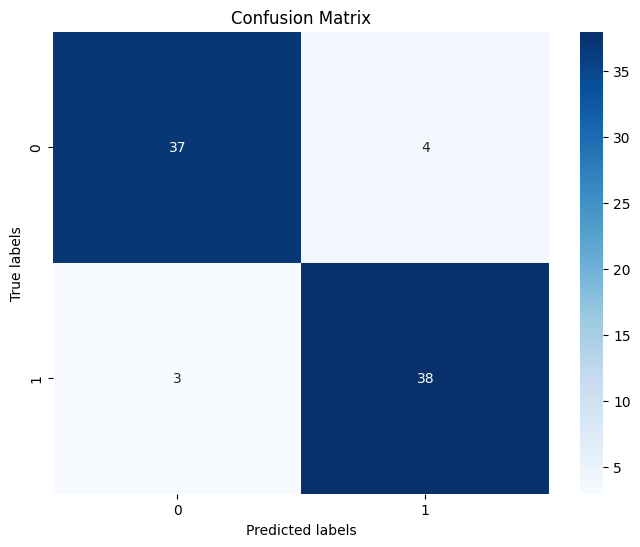

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(true_labels, predictions)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Calcular a precisão
precision = precision_score(true_labels, predictions)
print(f"Precisão do modelo: {precision:.2f}")

# Calcular o recall
recall = recall_score(true_labels, predictions)
print(f"Recall do modelo: {recall:.2f}")

# Calcular o F1-score
f1 = f1_score(true_labels, predictions)
print(f"F1-score do modelo: {f1:.2f}")

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predictions)
print("Matriz de Confusão:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [30]:
'''
Esta função captura os nomes das imagens de teste na mesma sequência que o Dataloader armazena as imagens.

Args:
data_loader (torch.utils.data.DataLoader): O DataLoader contendo as imagens de teste.
num_img (int): O número de imagens a serem processadas.

Returns:
None: A função não retorna um valor diretamente, mas atualiza a lista image_names com os nomes das imagens.
'''

image_names=[]
def show_image_name(data_loader, num_img):
    data_loader = torch.utils.data.DataLoader(data_loader, batch_size=10, shuffle=False)
    for i in range(num_img):
      image, filename = data_loader.dataset.samples[i]
      nome_do_arquivo = os.path.basename(image)
      image_names.append(nome_do_arquivo)
show_image_name(test_data_aux, 48)

Após realizar os calculos das métricas usando o conjunto das imagens de validação, vamos agora
obter as predições do modelo já treinado usando o conjunto dos dados de teste

In [42]:

import pandas as pd


test_loader = DataLoader(test_data, batch_size=42, shuffle=False)
# Lista para armazenar as previsões do modelo
predictions = []
# Lista para armazenar os rótulos verdadeiros
true_labels = []
teste = []

with torch.no_grad():
    # Iterar sobre os lotes de dados de teste
    for images, labels in test_loader:
        # Mover os dados para o dispositivo
        images = images.to(device)
        labels = labels.to(device)
        teste.append(images[1])
        # Realizar a inferência (previsões)
        outputs = model(images)

        # Obter as previsões convertendo as saídas do modelo em rótulos preditos
        _, predicted = torch.max(outputs, 1)

        # Adicionar as previsões e os rótulos verdadeiros às listas
        predictions.extend(predicted.cpu().numpy())
        #true_labels.extend(labels.cpu().numpy())


# Criar um DataFrame com as previsões e os rótulos de validação
df = pd.DataFrame({'Images names': image_names, 'Predictions': predictions})

# Especificar o caminho completo para salvar o arquivo CSV
caminho_salvamento = f"gdrive/MyDrive/logs_brain/predictions_and_labels.txt"

# Salvar o DataFrame em um arquivo CSV no caminho especificado
df.to_csv(caminho_salvamento, index=False)


Salva o arquivo .txt contendo as predições de cada imagem do conjunto teste


In [43]:
caminho_salvamento = f"gdrive/MyDrive/logs_brain/predictions_and_images.txt"

with open(caminho_salvamento, 'w') as arquivo:
    # Itera sobre os dados e escreve no arquivo
    for imagem, predicao in zip(image_names, predictions):
        arquivo.write(f"{imagem} {predicao}\n")


**Modelo pre-treinado eu obtive as seguintes métricas:**

Acurácia do modelo: 0.89
Precisão do modelo: 0.97
Recall do modelo: 0.80
F1-score do modelo: 0.88
Matriz de Confusão:
[[40  1]
 [ 8 33]]


De acordo com a matriz de confusão é possivel observar que o modelo obteve uma boa acurácia de 89%, o que indica que ele classificou corretamente a maioria das imagens. Além disso, a precisão foi alta, atingindo 97%, o que significa que a grande maioria das imagens classificadas como tumor estava correta. No entanto, o recall foi um pouco baixo, alcançando 80%, o que indica que algumas imagens de tumor podem não ter sido identificadas pelo modelo. O F1-score, que combina precisão e recall, foi de 88%, indicando um bom equilíbrio entre essas duas métricas. A matriz de confusão mostra que houve algumas previsões erradas, especialmente na identificação de imagens de tumor. No entanto como se trata de casos médicos de altissimos risco, é preferivel obter recall alto, mesmo que a precisão não seja tão alta. Um recall alto é especialmente importante porque indica a capacidade do modelo em identificar corretamente a maioria dos casos positivos, ou seja, no nosso caso, as pessoas que tem o tumor cerebral. Isso é crucial para garantir que o menor número possível de casos com tumor seja perdido, evitando assim diagnósticos falso negativos.

**Modelo iniciado com pesos aleatórios**

Após treinar e avaliar o modelo de classificação de imagens de cérebros, obtive resultados bem promissores que demonstram sua eficácia. Ao analisar as métricas de desempenho, foi possivel constatar que o modelo apresentou uma acurácia de 91%, o que significa que ele classificou corretamente a grande maioria das amostras do conjunto de validação.
A **precisão** do modelo, medida em 90%, indica que das amostras classificadas como positivas (representando tumores cerebrais), 90% realmente eram positivas. Isso nos traz confiança de que o modelo tem uma baixa taxa de falsos positivos, ou seja, de classificar erroneamente uma imagem saudável como contendo um tumor.

Além disso, o **recall** do modelo atingiu 93%, o que significa que ele conseguiu identificar corretamente a maioria das amostras positivas presentes no conjunto de teste. **Este resultado é especialmente relevante, pois indica uma baixa taxa de falsos negativos, ou seja, de classificar erroneamente uma imagem com tumor como sendo saudável.**


O **F1-score**, que combina precisão e recall, alcançou um sólido valor de 92%, reforçando a consistência geral do modelo na classificação das imagens de cérebros.

A análise da **matriz de confusão** nos fornece uma visão mais detalhada do desempenho do modelo, destacando os verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. Este exame minucioso revela que o modelo classificou corretamente a maioria das amostras, com apenas algumas classificações incorretas.

**Conclusão:**
Apesar do modelo pré-treinado ter alcançado uma precisão de 97%, seu recall de 80% foi consideravelmente baixo, indicando que o modelo deixou de identificar alguns casos positivos (com tumor). Por outro lado, o modelo iniciado com pesos aleatórios, embora tenha alcançado uma precisão de 80%, não tão alta quanto o modelo pré-treinado, apresentou um recall de 93%, indicando que comete poucos erros ao classificar imagens com câncer como saudáveis. Na medicina, é preferível ter um recall alto em vez de uma precisão alta porque um recall alto garante que casos positivos não sejam negligenciados, priorizando assim a detecção de condições médicas relevantes.

Dessa forma, para esse caso específico, o modelo iniciado com pesos aleatórios obteve um equilíbrio de métricas mais favorável, pois apresentou um recall mais alto e, portanto, uma capacidade superior de identificar casos positivos, mesmo que à custa de uma precisão ligeiramente menor.



**Otimização de parametros:**

Ajustei a **taxa de aprendizado** para melhorar as métricas do meu modelo, garantindo um treinamento estável e eficaz. Uma taxa muito alta pode causar ajustes excessivos, levando a oscilações ou divergência na otimização, enquanto uma taxa muito baixa pode retardar o treinamento. Devido a isso, a escolha cuidadosa da taxa de aprendizado é essencial para um desempenho otimizado.

Com o intuito de otimizar minhas métricas, ajustei o tamanho do **lote(batch size)** durante o treinamento.  Lotes menores facilitam a exploração ampla do espaço de parâmetros, potencialmente melhorando a generalização. Além disso, consomem menos memória e aceleram as inferências. Por outro lado, lotes maiores podem induzir overfitting sem regularização adequada. Com isso, a escolha do tamanho do lote é um equilíbrio entre estabilidade, velocidade, uso de memória e capacidade de generalização.


Usar **shuffle=True** do Dataloader durante o treinamento é benéfico porque isso embaralha os dados antes de cada época de treinamento. Isso impede que o modelo aprenda a depender da ordem dos exemplos nos dados, o que pode levar ao overfitting e prejudicar a capacidade de generalização do modelo. Em vez disso, o embaralhamento dos dados garante que o modelo seja exposto a uma variedade de exemplos em cada iteração, ajudando-o a aprender padrões mais robustos e a generalizar melhor para dados não vistos. Em resumo, o uso de shuffle=True promove um treinamento mais eficaz e robusto, resultando em modelos mais capazes de lidar com diferentes situações e realizar previsões precisas.






#Treinando o modelo usando o **efficientnet**

O EfficientNet é uma família de arquiteturas de redes neurais convolucionais projetada para maximizar a eficiência computacional enquanto mantém um desempenho poderoso em tarefas de visão computacional, como classificação de imagens. Ele alcança isso otimizando conjuntamente a profundidade, largura e resolução da rede por meio de um método chamado escalamento composto. Isso resulta em modelos mais eficientes em termos de computação, permitindo que sejam treinados e implantados em dispositivos com recursos limitados, como smartphones e dispositivos embarcados, sem comprometer significativamente o desempenho. Em resumo, o EfficientNet oferece um equilíbrio único entre eficiência e desempenho, tornando-o uma escolha popular em uma variedade de aplicações de visão computacional.


**Referências:**

Tan, Mingxing, and Quoc Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." International conference on machine learning. PMLR, 2019.

https://keras.io/api/applications/efficientnet/

In [14]:
!pip install efficientnet-pytorch --quiet

  Preparing metadata (setup.py) ... done


In [33]:
hparams_eff = {"experiment_name": "Test_ResNet_1",  # experiment name identifies the run for later
           "max_epochs": 30,  # number of epochs to train
           "batch_size_train": 64,  # size of batch
           "batch_size_val": 64,  # size of batch
           "nworkers": mp.cpu_count(),  # number of workers to use in parallel loading
           "nout": 2,  # number of classes
           "nin": 3,  # number of channels of the input image
           "lr": 1e-3,  # learning rate
           "wd": 1e-5,  # weight decay for optimizer
           "cpu": False,  # forces using the CPU
           }


In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt


train_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/train/"
val_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/val/"
test_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/test/"


# Carregar e pré-processar os conjuntos de dados de treinamento e validação
# Definir transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensiona as imagens para 224x224 pixels
    transforms.CenterCrop(90),
    transforms.ToTensor(),           # Converte as imagens para tensores
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza os pixels das imagens
])

# Carregar conjuntos de dados de treinamento e validação
train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_data_dir, transform=transform)

# Cria DataLoader para os conjuntos de dados gerados acima, nas quais foram combinado as imagens originais com as imagens aumentadas.
train_loader = torch.utils.data.DataLoader(combined_data_set_train, batch_size=hparams_eff["batch_size_train"], shuffle=True)
val_loader = torch.utils.data.DataLoader(combined_data_set_val, batch_size=hparams_eff["batch_size_val"], shuffle=False)



O código abaico cria, configura e prepara um modelo EfficientNet pré-treinado para treinamento em uma tarefa de classificação de imagens, definindo a camada de classificação final, a função de perda e o otimizador necessários para o treinamento.

In [37]:
from efficientnet_pytorch import EfficientNet

# Carregar um EfficientNet-B0 pré-treinado
model = EfficientNet.from_pretrained('efficientnet-b0')

# Atualizar o número de classes na camada de classificação final para corresponder ao seu problema
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Define  a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams_eff["lr"])


Loaded pretrained weights for efficientnet-b0


In [38]:
log_dir = f"gdrive/MyDrive/logs_brain"

for epoch in range(hparams_eff["max_epochs"]):
    model.train()  # Colocar o modelo no modo de treinamento
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zerar os gradientes
        outputs = model(inputs)  # Passar os dados de entrada pelo modelo
        loss = criterion(outputs, labels)  # Calcular a perda
        loss.backward()  # Calcular gradientes
        optimizer.step()  # Atualizar pesos

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{hparams_eff["max_epochs"]}], Loss: {epoch_loss:.4f}')

    import torch

for epoch in range(hparams_eff["max_epochs"]):
    model.train()  # Colocar o modelo no modo de treinamento
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zerar os gradientes
        outputs = model(inputs)  # Passar os dados de entrada pelo modelo
        loss = criterion(outputs, labels)  # Calcular a perda
        loss.backward()  # Calcular gradientes
        optimizer.step()  # Atualizar pesos

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{hparams_eff["max_epochs"]}], Loss: {epoch_loss:.4f}')








Epoch [1/30], Loss: 0.7343
Epoch [2/30], Loss: 0.2205
Epoch [3/30], Loss: 0.0728
Epoch [4/30], Loss: 0.0341
Epoch [5/30], Loss: 0.0140
Epoch [6/30], Loss: 0.0164
Epoch [7/30], Loss: 0.0047
Epoch [8/30], Loss: 0.0092
Epoch [9/30], Loss: 0.0032
Epoch [10/30], Loss: 0.0026
Epoch [11/30], Loss: 0.0016
Epoch [12/30], Loss: 0.0362
Epoch [13/30], Loss: 0.0015
Epoch [14/30], Loss: 0.0099
Epoch [15/30], Loss: 0.0340
Epoch [16/30], Loss: 0.0044
Epoch [17/30], Loss: 0.0032
Epoch [18/30], Loss: 0.0091
Epoch [19/30], Loss: 0.0047
Epoch [20/30], Loss: 0.0022
Epoch [21/30], Loss: 0.0012
Epoch [22/30], Loss: 0.0087
Epoch [23/30], Loss: 0.0014
Epoch [24/30], Loss: 0.0570
Epoch [25/30], Loss: 0.0213


KeyboardInterrupt: 

In [ ]:
# Salva o modelo
checkpoint_path = log_dir +'/'+ f"model_epoch_eff{epoch+1}.ckpt"
torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': epoch_loss
}, checkpoint_path)

Exibe as métricas do modelo com base nas imagens de treinamento

Acurácia no conjunto de validação: 0.9146
Precisão no conjunto de validação: 0.9474
Recall no conjunto de validação: 0.8780
F1-score no conjunto de validação: 0.9114
Matriz de confusão:
[[39  2]
 [ 5 36]]


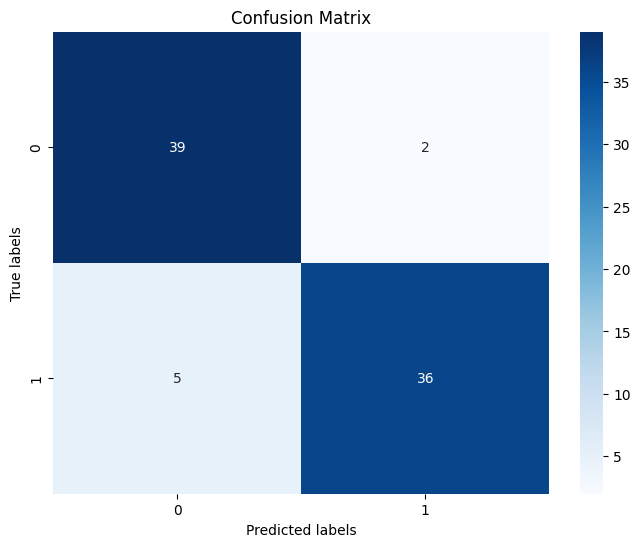

In [ ]:
# Carrega o modelo e exibe as métricas de treinamento do modelo
model_path = log_dir +'/'+ f"model_epoch_eff10.ckpt"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()  # Colocar o modelo no modo de avaliação
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Acurácia no conjunto de validação: {accuracy:.4f}')
print(f'Precisão no conjunto de validação: {precision:.4f}')
print(f'Recall no conjunto de validação: {recall:.4f}')
print(f'F1-score no conjunto de validação: {f1:.4f}')
print(f'Matriz de confusão:\n{conf_matrix}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

O modelo EfficientNet demonstrou um desempenho robusto no conjunto de validação, conforme evidenciado pelas métricas de avaliação. Com uma acurácia de 91,46%, o modelo classificou corretamente a grande maioria das amostras, refletindo sua capacidade de discernir entre as classes saudaveis e as classes com tumor.

A precisão do modelo, alcançando 94,74%, destaca sua habilidade de identificar corretamente as amostras positivas(com tumor), minimizando assim os falsos positivos. Por outro lado, o recall de 87,80% indica a capacidade do modelo de capturar a maioria das amostras positivas, evidenciando sua sensibilidade na detecção dos verdadeiros positivos.

Além disso, o F1-score de 91,14% fornece uma medida balanceada do desempenho do modelo, considerando tanto precisão quanto recall. Essa métrica reforça a consistência geral do modelo na classificação das amostras.

A análise da matriz de confusão revela ainda mais detalhes sobre o desempenho do modelo. Com um pequeno número de falsos positivos (2) e falsos negativos (5), o modelo demonstra uma capacidade sólida de distinguir entre as classes, minimizando assim as classificações errôneas.

Em resumo, as métricas e a matriz de confusão indicam que o modelo EfficientNet está bem ajustado para a tarefa de classificação no conjunto de validação.